# Extreme Rainfall

In [2]:
import sys

import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.colors import get_df_col, plotting_style

sys.path.append("../../../functions")
from data_downloaders import GHCN
plotting_style()

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [3]:
df_country = GHCN.get_country_code(country)
print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

The GHCN code for Palau is PS


In [4]:
df_stations = GHCN.download_stations_info()
df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
print(f'There are {df_country_stations.shape[0]} stations in {country}')

There are 13 stations in Palau


In [5]:
GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'

In [6]:
id = 'PSW00040309' # Koror Station
dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]

/Users/laurac/Documents/HAWAII/repository_GItHub/CC_indicators/notebooks_historical/atmosphere/3_rainfall/../../../functions/data_downloaders.py:169: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url_download, na_values=['-9999'])


In [7]:
data = dict_prcp[0]['data']
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

In [8]:
datag = data.groupby(data.index.year).max()
datag.index = pd.to_datetime(datag.index, format = '%Y')


In [9]:
dict_plot = [{'data' : datag, 'var' : 'PRCP', 'ax' : 1, 'label':f'Annual Maxima'},]

In [10]:
plot_timeseries_interactive(dict_plot, trendline = True);

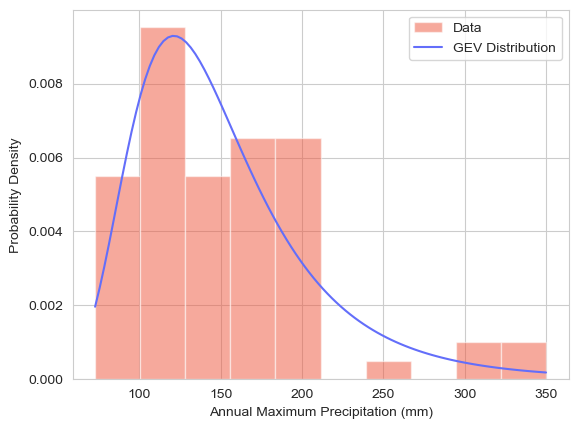

In [11]:
from scipy.stats import genextreme
import matplotlib.pyplot as plt
# Fit the data to GEV distribution
params = genextreme.fit(datag)

# Plot the histogram
plt.hist(datag, bins=10, density=True, alpha=0.5, label='Data', color = get_df_col()[1])

# Generate the GEV distribution using the fitted parameters
gev_dist = genextreme(*params)

# Plot the GEV distribution
x = np.linspace(datag.min(), datag.max(), 100)
plt.plot(x, gev_dist.pdf(x), '-', color = get_df_col()[0], label='GEV Distribution')

plt.xlabel('Annual Maximum Precipitation (mm)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [12]:
nsims = 1000
years_sim = 100  # years of precipitation to simulate

# use simulated GEVs
var_sim = np.zeros([years_sim, nsims])*np.nan  # initialize output numpy array
for sim in range(nsims):
    
    var_sim[:, sim] = gev_dist.rvs(size=years_sim)

var_sim = var_sim.T 
time_sim = np.arange('1970-10-01', '{0}-10-01'.format(1970+years_sim), dtype='datetime64[Y]')
 

In [13]:
# aux func for calculating rp time
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

# historical rp time and sorted annual maxima
trp_hist = t_rp(np.unique(data.index.year))
trp_hist_val = np.sort(data['PRCP'].groupby(data.index.year).max().values)

# simulation rp time and sorted annual maxima
trp_sim = t_rp(time_sim)
trp_sim_val = np.sort(var_sim)

# calculate simulation maxima percentiles
p95 = np.percentile(trp_sim_val, 100-5/2.0, axis=0,)
p50 = np.percentile(trp_sim_val, 50, axis=0,)
p05 = np.percentile(trp_sim_val, 5/2.0, axis=0,)

In [14]:
import plotly.graph_objects as go

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trp_sim, y=p95, mode='lines', name='P95', marker_color='mediumturquoise'))
fig.add_trace(go.Scatter(x=trp_sim, y=p05, mode='lines', name='P05', marker_color='mediumturquoise',  fill='tonexty', fillcolor='rgba(0, 181, 204, 0.10)'))
fig.add_trace(go.Scatter(x=trp_sim, y=p50, mode='lines', name='P50', marker_color='black'))
fig.add_trace(go.Scatter(x=trp_hist, y=trp_hist_val, mode='markers', name='Hist', marker_color='red'))


fig.update_xaxes(type="log")
fig.update_layout(    
    xaxis_title = "Return Period (years)",
    yaxis_title = "Precipitation (mm/d)",
    title = 'Annual Maxima',
    width=800, height=500
)
fig.show()